In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model
import mira
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

In [152]:
### Plotting Utils ###
COLORS=['red','green','blue','black','gold','magenta']

def setup_ax():
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax  = fig.add_subplot(111, axisbelow=True) # setup graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number Infected')
    return ax

def plot_trajectories(sol, tspan, data=None, focus=None, title=None, ax=None, colors=None):
    
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    var_list = [x for x in list(sol.keys()) if ("_sol" in x and x[:-4] in focus)] # skip beta, gamma, etc parameters
    if True in list("+" in x for x in focus):      # an aggregate state exists
        var_list += [i for i in focus if "+" in i] # add as a variable
    data_keys = [list(x[1].keys())[0] for x in data] if data else [] # get trained variables
    
    for i,var in enumerate(var_list):
        if colors: c = colors[i]
        else: c = COLORS[i]
        
        if "+" in var: # aggregate of >1 states
            add_vars = var.split("+")
            var_sol  = sum([sol[i+"_sol"] for i in add_vars])
        else: var_sol = sol[var]
        
        if len(sol[list(sol.keys())[3]]) == 1: # single trajectory, draw line
            ax.plot(tspan, var_sol.squeeze().detach().numpy(), c, alpha=0.5, lw=3, label=var+title)
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(var_sol, 0.05, dim=0).detach().numpy()
            I_hi  = torch.quantile(var_sol, 0.95, dim=0).detach().numpy()
            I_mid = (I_hi+I_low)/2
            ax.fill_between(torch_tspan[indices], I_low[indices], I_hi[indices],
                            alpha=0.2, color=c, label=var+title)
            ax.plot(tspan, I_mid, c, alpha=0.5, lw=3) # average value
        
        if var[:-4] in data_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=c)
    ax.legend()
    return ax

# Scenario 1
During the winter season in New York City (between Dec 1, 2020 and Mar 1, 2021), there was a peak of over 3.5k infected patients around January, overloading the hospital capacity of 3k.

## Question 1
How Likely is it that a 5% decrease in infection rate (beta) between Dec 1, 2020 and Mar 1, 2021 would have kept the infected (I+Iv) peak in January below 3k cases?

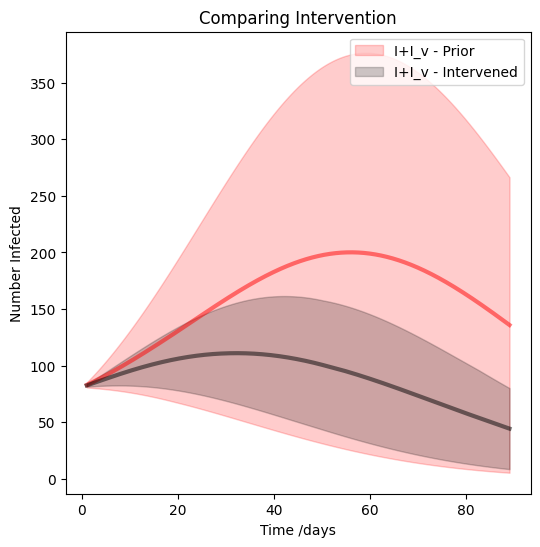

In [157]:
full_tspan = get_tspan(1, 89, 890) # 89 days, with 890 points sampled
raw_model  = load_petri_model("../../test/models/december_demo/SVIIvR_mira.json", add_uncertainty=True)
model = setup_model(raw_model, start_time=0, start_state=dict(S  =99919.0,
                                                              V  =0.0,
                                                              I  =81.0,
                                                              I_v=0.0,
                                                              R  =0.0))

prior_solution = sample(model, timepoints=full_tspan, num_samples=30)

# beta used to be 0.2, so 0.95*0.2 = 0.19
# starting at time 0.0 (first day)
interventions    = [(0.1,"beta",0.19)] # list[ tuple(time, param, value) , ... ]
intervened_model = intervene(model, interventions)
post_solution  = sample(intervened_model, timepoints=full_tspan, num_samples=30)

ax = plot_trajectories(prior_solution,full_tspan, focus=["I+I_v"], title=" - Prior", ax=setup_ax())
ax = plot_trajectories(post_solution ,full_tspan, focus=["I+I_v"], title=" - Intervened", ax=ax, colors=['black'])
plt.title("Comparing Intervention")
plt.show()

In [ ]:
# Probability of Exceedence to answer the question (Anirban)

GETRISK = computeRisk(
    model        = noisy_ode_model,
    qoi          = lambda y: threshold_exceedence(y, threshold=0.35, contexts=["I_obs"]), # I_obs was shorthand for I + I_v
    risk_measure = lambda z: pof(z, threshold=0.5),
    intervention_fun = INTERVENTION_FN,
    model_state  = final_observed_state,
    tspan        = new_tspan
)

POLICY = np.array([0.035])
SAMPLES = GETRISK.propagate_uncertainty(POLICY)
qois    = GETRISK.qoi(SAMPLES)

print(f"Risk value might be:\t{GETRISK.risk_measure(qois):.2f}")

## Question 2
How Likely is it that a stronger (25%) decrease in infection rate (beta) instead between Jan 1, 2020 and Mar 1, 2021 would have kept the infected (I+Iv) peak in January below 3k cases?

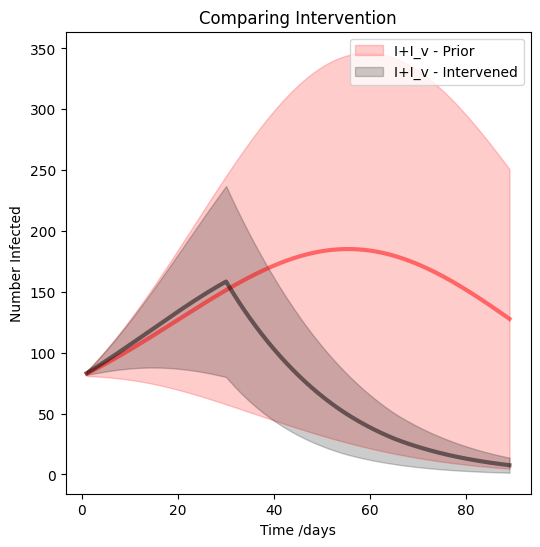

In [158]:
prior_solution = sample(model, timepoints=full_tspan, num_samples=30)

# beta used to be 0.2, so 0.75*0.2 = 0.15
# starting at time 30.0 (January)
interventions    = [(30.0,"beta",0.15)] # list[ tuple(time, param, value) , ... ]
intervened_model = intervene(model, interventions)
post_solution  = sample(intervened_model, timepoints=full_tspan, num_samples=30)

ax = plot_trajectories(prior_solution,full_tspan, focus=["I+I_v"], title=" - Prior", ax=setup_ax())
ax = plot_trajectories(post_solution ,full_tspan, focus=["I+I_v"], title=" - Intervened", ax=ax, colors=['black'])
plt.title("Comparing Intervention")
plt.show()

In [ ]:
# Probability of Exceedence to answer the question (Anirban)

GETRISK = computeRisk(
    model        = noisy_ode_model,
    qoi          = lambda y: threshold_exceedence(y, threshold=0.35, contexts=["I_obs"]),
    risk_measure = lambda z: pof(z, threshold=0.5),
    intervention_fun = INTERVENTION_FN,
    model_state  = final_observed_state,
    tspan        = new_tspan
)

POLICY = np.array([0.035])
SAMPLES = GETRISK.propagate_uncertainty(POLICY)
qois    = GETRISK.qoi(SAMPLES)

print(f"Risk value might be:\t{GETRISK.risk_measure(qois):.2f}")

## Question 3
What is the smallest change in beta in the second intervention (Jan 1 onwards) that will still keeps infections below 3k?

In [ ]:
# Old code Graham and I (Agustin) had working in January Hackathon

### how much mitigation do we need to keep H+Hv below 3K
from pyciemss.risk.ouu import computeRisk, solveOUU
from pyciemss.risk.qoi import threshold_exceedence
from pyciemss.risk.risk_measures import pof
from pyciemss.ODE.interventions import constant_intervention, parameter_intervention

ALPHA = 0.95

INTERVENTION_FN = lambda x: constant_intervention("betaSI", torch.from_numpy(x), new_tspan)

# Define problem specifics.
old_beta = 0.3
RISK_BOUND = 0.05
BETA_MIN = 0.
BETA_MAX = old_beta

BETA_INITIAL = 0.001

N_SAMPLES = int(1e2)
MAXITER = 10
TOL = 1e-5

OBJFUN = lambda x: x

GETRISK = computeRisk(
    model        = noisy_ode_model,
    qoi          = lambda y: threshold_exceedence(y, threshold=0.35, contexts=["I_obs"]),
    risk_measure = lambda z: pof(z, threshold=0.5),
    intervention_fun = INTERVENTION_FN,
    model_state  = final_observed_state,
    tspan        = new_tspan
)

O = solveOUU(x0          = BETA_INITIAL,
             objfun      = lambda x: np.abs(old_beta - x), # minimize difference
             constraints =[{'type':"ineq",'fun':lambda x: x - BETA_MIN}, #  low bound
                           {'type':"ineq",'fun':lambda x: BETA_MAX - x}, # high bound
                           {"type":"ineq","fun":lambda x: RISK_BOUND - GETRISK(x)}],
             optimizer_algorithm = "COBYLA",
             tol                 = TOL,
             options             = {"maxiter": MAXITER}
            )

sol = O.solve()

# Scenario 2